In [76]:
import gym
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [77]:
num_iterations = 20000 

initial_collect_steps = 100  
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000  

batch_size = 64  
learning_rate = 1e-3
log_interval = 200  

num_eval_episodes = 10  
eval_interval = 1000  

In [78]:
env = suite_gym.load('CartPole-v1')

In [79]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.01841126, -0.02973313, -0.00218904,  0.04342841], dtype=float32))
Next time step:
TimeStep(step_type=array(1), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.01900592,  0.16542014, -0.00132047, -0.24994437], dtype=float32))


In [80]:
train_py_env = suite_gym.load('CartPole-v1')
eval_py_env = suite_gym.load('CartPole-v1')

In [81]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [86]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, 
                                 activation=tf.keras.activations.relu, 
                                 kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

q_values_layer = tf.keras.layers.Dense(num_actions, 
                                       activation=None, 
                                       kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
                                       bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [31]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [32]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [33]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v1'))

In [34]:
time_step = example_environment.reset()

In [35]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>, state=(), info=())

In [36]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
    total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [37]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

24.7

In [38]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [39]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [40]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [41]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps) 

In [42]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [43]:
iterator = iter(dataset)
print(iterator)

In [44]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 87.09430694580078
step = 400: loss = 5.130100250244141
step = 600: loss = 1.663902759552002
step = 800: loss = 5.672111511230469
step = 1000: loss = 12.319089889526367
step = 1000: Average Return = 82.80000305175781
step = 1200: loss = 135.8038330078125
step = 1400: loss = 18.9317626953125
step = 1600: loss = 777.6038818359375
step = 1800: loss = 53.47575378417969
step = 2000: loss = 74.03176879882812
step = 2000: Average Return = 288.5
step = 2200: loss = 87.7959976196289
step = 2400: loss = 887.3899536132812
step = 2600: loss = 122.4480972290039
step = 2800: loss = 326.39959716796875
step = 3000: loss = 3308.8564453125
step = 3000: Average Return = 292.3999938964844
step = 3200: loss = 329.25213623046875
step = 3400: loss = 24189.96875
step = 3600: loss = 322.06317138671875
step = 3800: loss = 624.6636962890625
step = 4000: loss = 686.4808349609375
step = 4000: Average Return = 377.79998779296875
step = 4200: loss = 1565.2840576171875
step = 4400: loss = 737.564697

(22.14500160217285, 505.0)

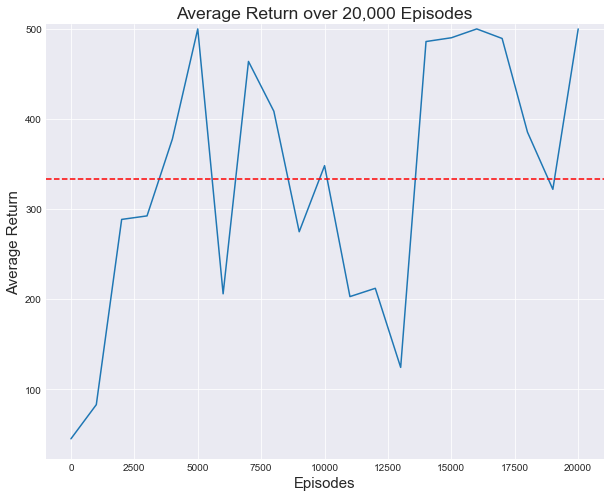

In [75]:
# The red line is the mean of the returns
plt.style.use('seaborn-darkgrid')
plt.subplots(figsize=(10,8))
plt.plot(range(0, num_iterations + 1, eval_interval), returns)
plt.axhline(y=np.mean(returns), color='r', ls='--')
plt.title('Average Return over 20,000 Episodes', size=17.5)
plt.ylabel('Average Return', size=15)
plt.xlabel('Episodes', size=15)
plt.ylim(top=505)